<a href="https://colab.research.google.com/github/EsserMishelle/nvda-time-series-forecasting/blob/main/Short_Term_Stock_Trend_Forecasting_FBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facebook Prophet

# Objective
The objective of this project is to forecast the short-term closing price of NVIDIA (NVDA) stock using classical time-series models and compare their performance using information criteria and forecast accuracy.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet

import seaborn as sns
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load NVDA price and volume and merge them together

In [3]:
# --- Load the two FILES ---
price_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_price_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)

volume_df = pd.read_csv(
    '/content/drive/MyDrive/stocks/stock_volume_2021_2026.csv',
    index_col='Date',
    parse_dates=True
)

# Keep only NVDA for now
p = price_df[[('NVDA_Close')]].copy()
v = volume_df[[('NVDA_Volume')]].copy()

# Rename column names
p.columns = ['nvda_close']
v.columns = ['nvda_volume']

# Merge price + volume by date
df = p.join(v, how='inner')


display(df.info())
print()

display(df.describe())
print()

display(df.head())
print()
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1278 entries, 2021-01-04 to 2026-02-04
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nvda_close   1278 non-null   float64
 1   nvda_volume  1278 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 30.0 KB


None

,nvda_close,nvda_volume
count,1278.000000,1.278000e+03
mean,69.329726,3.907986e+08
std,59.103824,1.843901e+08
min,11.212903,6.552850e+07
25%,19.515131,2.365302e+08
50%,42.327456,3.756440e+08
75%,121.585546,5.028558e+08
max,207.028473,1.543911e+09


,nvda_close,nvda_volume
Date,,
2021-01-04,13.076725,560640000
2021-01-05,13.367163,322760000
2021-01-06,12.579125,580424000
2021-01-07,13.306579,461480000
2021-01-08,13.239517,292528000


,nvda_close,nvda_volume
Date,,
2026-01-29,192.509995,171764400
2026-01-30,191.130005,179489500
2026-02-02,185.610001,165794100
2026-02-03,180.339996,204019600
2026-02-04,174.190002,207014100


In [4]:
# Create Prophet dataset
prophet_nvda = df['nvda_close'].reset_index()
prophet_nvda.columns = ['ds', 'y']
prophet_train = prophet_nvda.iloc[:-90]
prophet_test  = prophet_nvda.iloc[-90:]

prophet_nvda.head(10)

,ds,y
0,2021-01-04,13.076725
1,2021-01-05,13.367163
2,2021-01-06,12.579125
3,2021-01-07,13.306579
4,2021-01-08,13.239517
5,2021-01-11,13.583302
6,2021-01-12,13.446934
7,2021-01-13,13.493802
8,2021-01-14,13.163235
9,2021-01-15,12.823438


### Initialize the Prophet model
Prophet already includes: trend and atomatic changepoints

* Stock prices don't have meaningful daily/weekly seasonality.
* Yearly effects sometimes show up in tax cycles and earning cadence

In [5]:
# Training
# Trained only on TRAIN window
#
prophet_model = Prophet(yearly_seasonality=True,
                        weekly_seasonality=False,
                        daily_seasonality=False)

prophet_model.fit(prophet_train)

### Transform the dataset to Facebook Prophet required format.

In [6]:
HOLDOUT_DAYS = 90
FUTURE_DAYS = 30
periods = HOLDOUT_DAYS + FUTURE_DAYS  # 120

# Create future dates
prophet_future = prophet_model.make_future_dataframe(periods=periods, freq='B') #'B' for business days, 120 days

# Predict and generate forecast
prophet_forecast = prophet_model.predict(prophet_future)

display(prophet_forecast.tail())
print()
display(prophet_forecast.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1303,2026-03-06,178.025113,159.476902,185.999102,170.299166,186.027107,-5.891432,-5.891432,-5.891432,-5.891432,-5.891432,-5.891432,0.0,0.0,0.0,172.133681
1304,2026-03-09,178.350503,159.160276,185.135203,170.548651,186.511563,-6.181460,-6.181460,-6.181460,-6.181460,-6.181460,-6.181460,0.0,0.0,0.0,172.169043
1305,2026-03-10,178.458966,158.812742,185.423415,170.578157,186.771350,-6.223268,-6.223268,-6.223268,-6.223268,-6.223268,-6.223268,0.0,0.0,0.0,172.235698
1306,2026-03-11,178.567430,158.148168,186.435710,170.588319,187.109956,-6.239442,-6.239442,-6.239442,-6.239442,-6.239442,-6.239442,0.0,0.0,0.0,172.327987
1307,2026-03-12,178.675893,159.354275,185.933351,170.615605,187.353500,-6.232232,-6.232232,-6.232232,-6.232232,-6.232232,-6.232232,0.0,0.0,0.0,172.443661


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-04,17.503319,5.479221,26.430475,17.503319,17.503319,-1.324780,-1.324780,-1.324780,-1.324780,-1.324780,-1.324780,0.0,0.0,0.0,16.178539
1,2021-01-05,17.510316,5.269752,26.080572,17.510316,17.510316,-1.367824,-1.367824,-1.367824,-1.367824,-1.367824,-1.367824,0.0,0.0,0.0,16.142492
2,2021-01-06,17.517313,5.158433,26.796269,17.517313,17.517313,-1.427012,-1.427012,-1.427012,-1.427012,-1.427012,-1.427012,0.0,0.0,0.0,16.090301
3,2021-01-07,17.524310,5.707552,26.254919,17.524310,17.524310,-1.503832,-1.503832,-1.503832,-1.503832,-1.503832,-1.503832,0.0,0.0,0.0,16.020477
4,2021-01-08,17.531307,6.027964,27.177266,17.531307,17.531307,-1.599243,-1.599243,-1.599243,-1.599243,-1.599243,-1.599243,0.0,0.0,0.0,15.932063


In [7]:
prophet_eval = prophet_nvda.merge(
    prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds',
    how='left',
)

In [8]:
train_mask = prophet_eval['ds'] < prophet_test['ds'].min()
test_mask  = (
    (prophet_eval['ds'] >= prophet_test['ds'].min()) &
    (prophet_eval['ds'] <= prophet_test['ds'].max())
)
prophet_train_eval = prophet_eval[train_mask]
prophet_test_eval  = prophet_eval[test_mask]

In [9]:
train_clean = prophet_train_eval.dropna(subset=['yhat'])
test_clean  = prophet_test_eval.dropna(subset=['yhat'])

print("NaNs in train yhat:", prophet_train_eval['yhat'].isna().sum())
print("NaNs in test yhat:", prophet_test_eval['yhat'].isna().sum())
print("Train rows used:", len(train_clean), " / ", len(prophet_train_eval))
print("Test rows used:", len(test_clean), " / ", len(prophet_test_eval))


NaNs in train yhat: 0
NaNs in test yhat: 0
Train rows used: 1188  /  1188
Test rows used: 90  /  90


Align prophet_train_eval and prophet_test_eval row-by-row

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(actual, pred):
  actual = np.array(actual)
  pred = np.array(pred)
  return np.mean(np.abs((actual - pred) / actual)) * 100

mae_train = mean_absolute_error(train_clean['y'], train_clean['yhat'])
mae_test  = mean_absolute_error(test_clean['y'], test_clean['yhat'])

rmse_train = np.sqrt(mean_squared_error(train_clean['y'], train_clean['yhat']))
rmse_test  = np.sqrt(mean_squared_error(test_clean['y'], test_clean['yhat']))

mape_train = mape(train_clean['y'], train_clean['yhat'])
mape_test  = mape(test_clean['y'], test_clean['yhat'])

prophet_metrics = pd.DataFrame({
    'Model': ['Prophet','Prophet'],
    'Set': ['Train','Test'],
    'MAE': [mae_train, mae_test],
    'RMSE': [rmse_train, rmse_test],
    'MAPE': [mape_train, mape_test]
})
prophet_metrics.to_csv('prophet_metrics.csv', index=False)
display(prophet_metrics)

,Model,Set,MAE,RMSE,MAPE
0,Prophet,Train,5.803535,8.072655,13.315388
1,Prophet,Test,16.673649,18.176849,8.851516


#### The Prophet metric has a significant gap between train rmse ≈ 8.07 and test rmse ≈ 18.18. This means Prophet is underfitting the volatility.
#### It captures smooth trend but misses rapid market moves. This is completely normal for Prophet on equities.
#### This model does not respond well to momentum, volatility clusters, regime changes, or market shocks.

### Charting Future 30 days Forecast

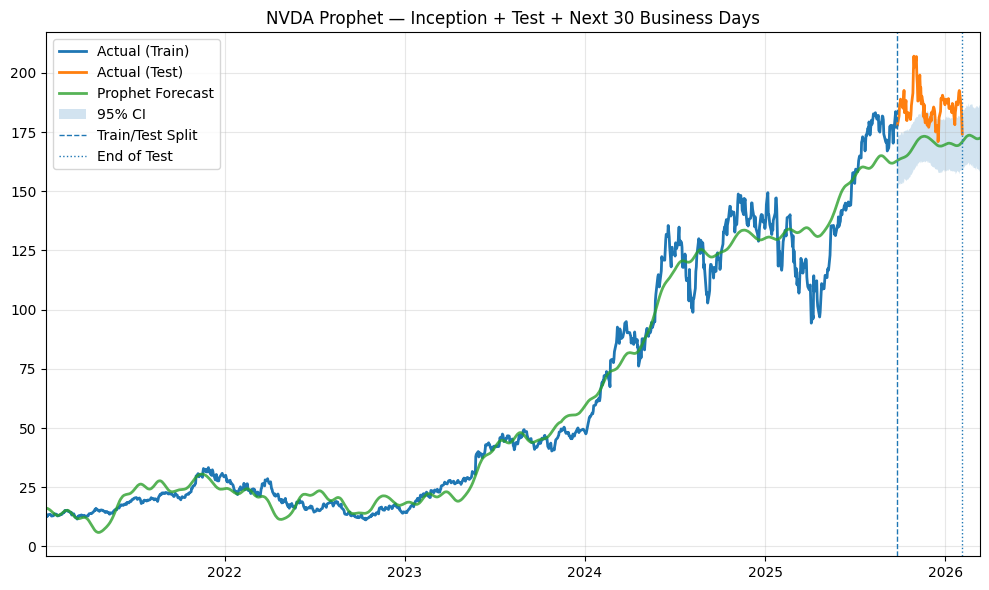

Split date: 2025-09-25 00:00:00
Test end: 2026-02-04 00:00:00
Forecast end: 2026-03-12 00:00:00


In [11]:
split_date = prophet_train['ds'].max()
test_end   = prophet_test['ds'].max()
forecast_end = prophet_forecast['ds'].max()

plt.figure(figsize=(10,6))

plt.plot(prophet_train['ds'], prophet_train['y'], label='Actual (Train)', linewidth=2)
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual (Test)', linewidth=2)

plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', linewidth=2, alpha=0.8)

future_only = prophet_forecast[prophet_forecast['ds'] > split_date]
plt.fill_between(future_only['ds'], future_only['yhat_lower'], future_only['yhat_upper'], alpha=0.2, label='95% CI')

plt.axvline(split_date, linestyle='--', linewidth=1, label='Train/Test Split')
plt.axvline(test_end, linestyle=':', linewidth=1, label='End of Test')

# Force x-axis to include forecast
plt.xlim(prophet_nvda['ds'].min(), forecast_end)

plt.title('NVDA Prophet Since Train + Test + Next 30 Business Days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Split date:", split_date)
print("Test end:", test_end)
print("Forecast end:", forecast_end)


#### This figure shows Prophet trained on historical NVDA prices, evaluated on a 90-day test window, and used to generate a 30-business-day forward forecast with 95% confidence intervals. It confirms that Prophet produces a relatively smooth projection that does not capture short-term volatility.

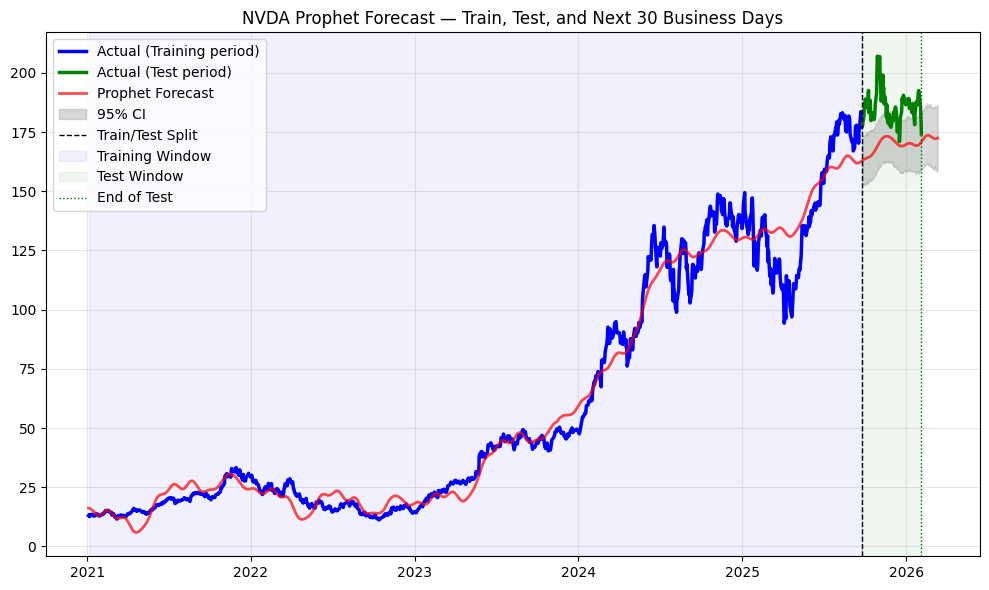

Test window start: 2025-09-26 00:00:00
Test window end:   2026-02-04 00:00:00
Forecast end:      2026-03-12 00:00:00


In [23]:
# Blue and green lines show actual NVDA prices; red line shows Prophet’s predictions.
plt.figure(figsize=(10,6))

# Actual data
plt.plot(prophet_train['ds'], prophet_train['y'],
         label='Actual (Training period)', linewidth=2.5, color='blue')

plt.plot(prophet_test['ds'], prophet_test['y'],
         label='Actual (Test period)', linewidth=2.5, color='green')

# Forecast
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'],
         label='Prophet Forecast', color='red', linewidth=2, alpha=0.7)

# Only shade future uncertainty
split_date = prophet_train['ds'].max()

forecast_future = prophet_forecast[
    prophet_forecast['ds'] > split_date
]

plt.fill_between(
    forecast_future['ds'],
    forecast_future['yhat_lower'],
    forecast_future['yhat_upper'],
    color='gray',
    alpha=0.3,
    label='95% CI'
)

# Train/Test split line
plt.axvline(
    x=split_date,
    color='black',
    linestyle='--',
    linewidth=1,
    label='Train/Test Split'
)

plt.title('NVDA Prophet Forecast — Train, Test, and Next 30 Business Days')



plt.axvspan(
    prophet_train['ds'].min(),
    prophet_train['ds'].max(),
    color='blue',
    alpha=0.06,
    label='Training Window'
)

plt.axvspan(
    prophet_train['ds'].max(),
    prophet_test['ds'].max(),
    color='green',
    alpha=0.06,
    label='Test Window'
)

plt.axvline(
    x=prophet_test['ds'].max(),
    color='darkgreen',
    linestyle=':',
    linewidth=1,
    label='End of Test'
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("Test window start:", prophet_test['ds'].min())
print("Test window end:  ", prophet_test['ds'].max())
print("Forecast end:     ", prophet_forecast['ds'].max())

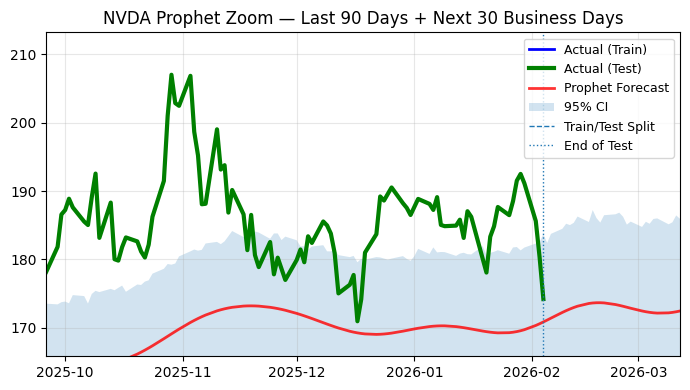

Zoom start: 2025-09-26 00:00:00
Test end: 2026-02-04 00:00:00
Forecast end: 2026-03-12 00:00:00


In [28]:
# ---------- ZOOMED VERSION OF YOUR PROPHET CHART ----------

plt.figure(figsize=(7,4))


plt.plot(prophet_train['ds'], prophet_train['y'],
         label='Actual (Train)', linewidth=2, color='blue' )

plt.plot(prophet_test['ds'], prophet_test['y'],
         label='Actual (Test)', linewidth=3, color='green')

plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'],
         label='Prophet Forecast', linewidth=2, alpha=0.8, color='red')

future_only = prophet_forecast[prophet_forecast['ds'] > split_date]
plt.fill_between(
    future_only['ds'],
    future_only['yhat_lower'],
    future_only['yhat_upper'],
    alpha=0.2, label='95% CI'
)

plt.axvline(split_date, linestyle='--', linewidth=1, label='Train/Test Split')
plt.axvline(test_end, linestyle=':', linewidth=1, label='End of Test')

# ----- THIS IS THE ZOOM -----
zoom_start = prophet_test['ds'].min()            # start of last 90 days
zoom_end   = forecast_end                        # end of 30-day forecast

plt.xlim(zoom_start, zoom_end)

# Optional: tighten y-axis so the zoom is readable
y_min = prophet_test['y'].min() * 0.97
y_max = prophet_test['y'].max() * 1.03
plt.ylim(y_min, y_max)

# ----- LABELS -----
plt.title('NVDA Prophet Zoom — Last 90 Days + Next 30 Business Days')
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Zoom start:", zoom_start)
print("Test end:", test_end)
print("Forecast end:", forecast_end)


## Prophet Summary:
### Base on the metrics, it is shown that direct supervised models outperform structural decomposition at short horizons.
### Prophet does not dramatically outperform simple regression.
### Forecast uncertainty grows nonlinearly with horizon.
